```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Python 2.7 compatibility
from __future__ import print_function

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import mpld3

import subprocess
import os
import gc
import datetime

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#Finally, import our simulator
from SWESimulators import Common, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, PlotHelper

In [2]:
import atexit
def exitfunc():
    #Clean up old context if any:
    if 'cuda_context' in globals():
        print("Cleaning up CUDA context!")
        cuda.Context.pop()
        global cuda_context
        del cuda_context
        gc.collect()
    else:
        print("No CUDA context available")
        gc.collect()
        
atexit.register(exitfunc)
exitfunc()
    
cuda_context = Common.CudaContext(verbose=True, blocking=False)


No CUDA context available
CUDA version (9, 1, 0)
Driver version 9010
Using GeForce 840M
 => compute capability: (5, 0)
 => memory: 2048.0 MB
Created context <473608042576>


In [3]:
#Misc plotting setup
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1', 5]) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':', '-.']) +
                       #cycler('markersize', [5, 5, 5, 5, 5, 5]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k', 'k']) )    

#Set large figure sizes
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'
#plt.rcParams['legend.markerscale'] = 1.0
#plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.markeredgewidth'] = 1.5
#plt.rcParams['savefig.dpi'] = 400

In [4]:
def save_figure(fig, stem):
    fig_filename = "convergence_shock1d_" + stem + ".pdf"
    
    image_text = fig_filename + "\nCreated " + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    #ax = fig.gca()
    #pos1 = ax.get_position() # get the original position 
    #pos2 = [pos1.x0 + 0.3, pos1.y0 + 0.3,  pos1.width / 2.0, pos1.height / 2.0] 
    #ax.set_position(pos2) # set a new position
    
    #fig.gca().annotate(image_text, xy=(1.1, 0), xycoords='figure fraction', fontsize=10,
    #                   horizontalalignment='right', verticalalignment='bottom')
    t = plt.figtext(-0.1, .9, image_text, rotation='vertical')
    
    legend = fig.gca().legend_
    if (legend != None):
        fig.savefig(fig_filename, bbox_extra_artists=(legend,t, ), bbox_inches='tight')
    else:
        fig.savefig(fig_filename)

In [5]:
def gen_reference(nx):
    csv_filename = 'shock1d_ref_nx=' + str(nx) + '.csv'

    #If we do not have the data, generate it    
    if (not os.path.isfile(csv_filename)):
        print("Generating new reference!")
        swashes_path = r'C:\Users\anbro\Documents\programs\SWASHES-1.03.00_win\bin\swashes_win.exe'

        swashes_args = [\
                        '1', # 1D problems \
                        '3', # Dam breaks \
                        '1', # Domain 1 \
                        '1', # Wet domain no friction
                        str(nx) #Number of cells X
                       ]

        with open(csv_filename, 'w') as csv_file:
            p = subprocess.check_call([swashes_path] + swashes_args, stdout=csv_file)

    reference = np.genfromtxt(csv_filename, comments='#', delimiter='\t', skip_header=0, usecols=(0, 1, 2))
    x, h, u = reference[:, 0], reference[:, 1], reference[:, 2]
    return x, h, h*u

In [6]:
def downsample(highres_solution, factor):
    if (len(highres_solution.shape) == 1):
        highres_solution = highres_solution.reshape((1, highres_solution.size))

    assert(highres_solution.shape[1] % factor == 0)
    ny = highres_solution.shape[0] 
    nx = highres_solution.shape[1] / factor

    if (factor == 1):
        return highres_solution
    else:
        
        return highres_solution.reshape([int(ny), int(1), int(nx), int(factor)]).mean(3).mean(1)

In [7]:
def wall_boundary_conditions(data, num_ghost_cells):
    data[0:num_ghost_cells,:] = data[2*num_ghost_cells-1:num_ghost_cells-1:-1,:]
    data[-num_ghost_cells:,:] = data[-num_ghost_cells-1:-2*num_ghost_cells-1:-1,:]
    data[:,0:num_ghost_cells] = data[:,2*num_ghost_cells-1:num_ghost_cells-1:-1]
    data[:,-num_ghost_cells:] = data[:,-num_ghost_cells-1:-2*num_ghost_cells-1:-1]
    return data

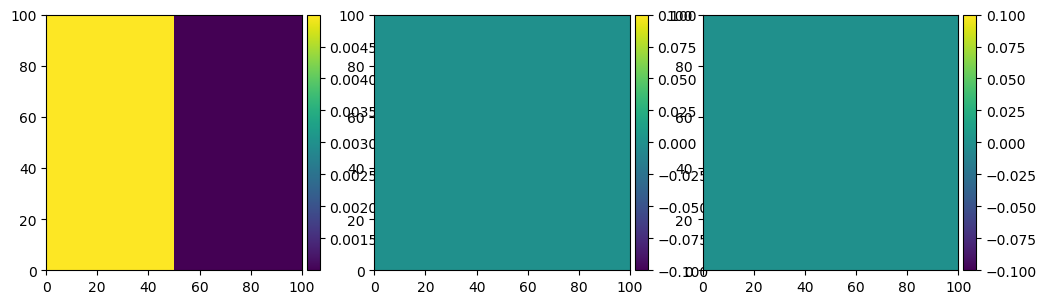

[0.1, 1.0, 0.1917647230683736]


In [8]:
def gen_test_data(nx, ref_nx, g, num_ghost_cells):
    assert(num_ghost_cells >= 1)
    ref_ny = num_ghost_cells
    ny = ref_ny
    
    dx = 10.0 / float(nx)
    dy = 1.0

    h_highres = np.zeros((ref_ny, ref_nx))
    h = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);

    #Create dam break
    x = np.linspace(0, 10, ref_nx)
    
    h_highres = np.where(x < 5, 0.005, 0.001);    
    h[num_ghost_cells:-num_ghost_cells, num_ghost_cells:-num_ghost_cells] = downsample(h_highres, ref_nx/nx)
    h = wall_boundary_conditions(h, num_ghost_cells);
    
    max_h_estimate = 0.005
    max_u_estimate = 0.3
    dt = min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))
    
    return h, hu, hv, dx, dy, dt


h, hu, hv, dx, dy, dt = gen_test_data(nx=100, ref_nx=1000, g=9.81, num_ghost_cells=2)

plt.figure()
ax=plt.subplot(1,3,1)
im=plt.imshow(h, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax=plt.subplot(1,3,2)
im=plt.imshow(hu, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax=plt.subplot(1,3,3)
im=plt.imshow(hv, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

print([dx, dy, dt])

In [9]:
def gen_filename(simulator, nx):
    return "shock1d_" + str(simulator.__name__) + "_" + str(nx) + ".npz"

In [10]:
def sanity_check(variable, variable_name):
    maxval = np.amax(variable)
    minval = np.amin(variable)
    if (np.isnan(maxval) or np.isnan(minval)):
        print("=== WARNING ===")
        print(variable_name + " contains NaN values")
        print("=== WARNING ===")

def run_benchmark(datafilename, simulator, courant_number, nx, ref_nx, ghost_cells, g=9.81, force_rerun=False, transpose=False):
    datafilename = gen_filename(simulator, nx)

    if (os.path.isfile(datafilename) and force_rerun == False):
        print("=== WARNING ===")
        print("Existing simulation exists, skipping simulation")
        print("=== WARNING ===")
    else:
        h0, hu0, hv0, dx, dy, dt = gen_test_data(nx, ref_nx, g, ghost_cells)
        ny = ghost_cells
        dt = dt * courant_number

        #Initialize simulator
        with Common.Timer(simulator.__name__ + "_" + str(nx)) as timer:
            if (transpose):
                h0 = np.ascontiguousarray(np.transpose(h0))
                hu0, hv0 = np.ascontiguousarray(np.transpose(hv0)), np.ascontiguousarray(np.transpose(hu0))
                dx, dy = dy, dx
                nx, ny = ny, nx
                
            sim = simulator(cuda_context, \
                            h0, hu0, hv0, \
                            nx, ny, \
                            dx, dy, dt, \
                            g)

            t, nt = sim.step(6.0)
            h, hu, hv = sim.download()

            if (transpose):
                h = np.transpose(h)
                hu, hv = np.ascontiguousarray(np.transpose(hv)), np.ascontiguousarray(np.transpose(hu))
                
            h = h[ghost_cells, ghost_cells:-ghost_cells]
            hu = hu[ghost_cells, ghost_cells:-ghost_cells]
            hv = hv[ghost_cells, ghost_cells:-ghost_cells]


            sanity_check(h, "h")
            sanity_check(hu, "hu")
            sanity_check(hv, "hv")

            np.savez_compressed(datafilename, h=h, hu=hu, hv=hv)
        
    gc.collect() # Force run garbage collection to free up memory
    
    return [timer.secs, nt, dt]

In [11]:
reference_nx = 16384
domain_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096]
simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
simulator_ghost_cells = [1, 1, 1, 2, 2, 2, 2]
simulator_reference = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
simulator_courant_numbers = [0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]
force_rerun=True
transpose=True

#simulators = [HLL2.HLL2, WAF.WAF]
#simulator_ghost_cells = [2, 2]
#simulator_reference = [HLL2.HLL2, WAF.WAF]
#simulator_courant_numbers = [0.95, 0.95]
#force_rerun=True

#Warmup to compile kernels
with Common.Timer("warmup", verbose=False) as timer:
    for i in range(len(simulators)):
        run_benchmark("warmup", 
                      simulators[i], 
                      simulator_courant_numbers[i], 
                      16, 16, 
                      simulator_ghost_cells[i], 
                      force_rerun=force_rerun,
                      transpose=transpose)
print("Completed warmup in {:} s".format(timer.secs))
        
with Common.Timer("simulation", verbose=False) as timer:
    for i in range(len(simulators)):        
        for j, nx in enumerate(domain_sizes):
            datafilename = gen_filename(simulators[i], nx)
            run_benchmark(datafilename, \
                          simulators[i], \
                          simulator_courant_numbers[i], \
                          nx, reference_nx, \
                          simulator_ghost_cells[i], \
                          force_rerun=force_rerun,
                          transpose=transpose)
            gc.collect()
            
        # Run reference with a low CFL-number
        datafilename = gen_filename(simulators[i], reference_nx)
        run_benchmark(datafilename, 
                      simulators[i], 
                      simulator_courant_numbers[i] * 0.5, 
                      reference_nx, reference_nx, 
                      simulator_ghost_cells[i], 
                      force_rerun=force_rerun,
                      transpose=transpose)
print("Completed simulation in {:} s".format(timer.secs))

=> LxF_16 9704.824448 ms
=> FORCE_16 4928.640366 ms
=> HLL_16 5731.522560 ms
=> HLL2_16 5418.677807 ms
=> KP07_16 5644.765615 ms
=> KP07_dimsplit_16 5425.083160 ms
=> WAF_16 4985.572577 ms
Completed warmup in 42.30030941963196 s
=> LxF_32 21.013498 ms
=> LxF_64 20.006895 ms
=> LxF_128 22.994280 ms
=> LxF_256 44.026613 ms
=> LxF_512 50.032139 ms
=> LxF_1024 73.047876 ms
=> LxF_2048 162.106991 ms
=> LxF_4096 468.312979 ms
=> LxF_16384 13897.776365 ms
=> FORCE_32 23.014545 ms
=> FORCE_64 27.017117 ms
=> FORCE_128 23.022175 ms
=> FORCE_256 26.024342 ms
=> FORCE_512 55.036783 ms
=> FORCE_1024 67.044497 ms
=> FORCE_2048 186.131001 ms
=> FORCE_4096 646.647692 ms
=> FORCE_16384 19444.917917 ms
=> HLL_32 20.005941 ms
=> HLL_64 26.018381 ms
=> HLL_128 37.025928 ms
=> HLL_256 38.017988 ms
=> HLL_512 42.029142 ms
=> HLL_1024 88.058472 ms
=> HLL_2048 241.166353 ms
=> HLL_4096 867.717266 ms
=> HLL_16384 26067.655802 ms
=> HLL2_32 22.012472 ms
=> HLL2_64 30.046701 ms
=> HLL2_128 23.009777 ms
=> HLL2_

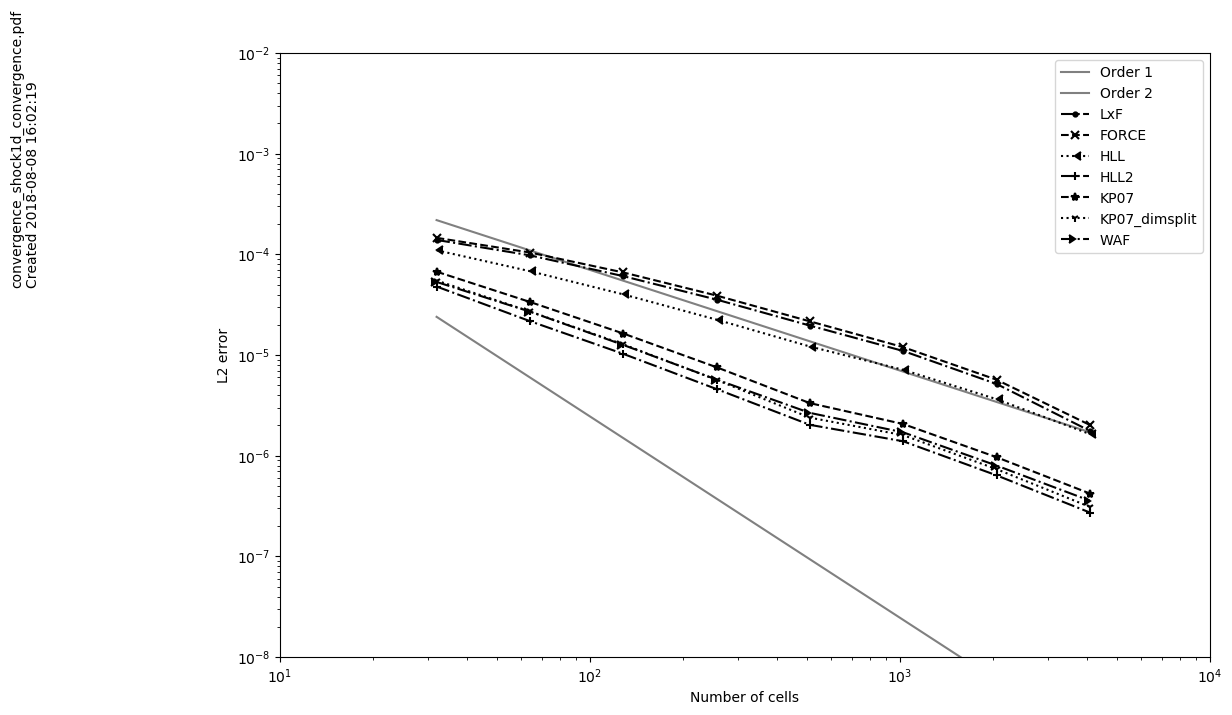

In [12]:
use_analytic = False
conservation = np.zeros((len(simulators), len(domain_sizes)))
error = np.zeros((len(simulators), len(domain_sizes)))

for i, simulator in enumerate(simulators):
    if (use_analytic):
        #Read the reference solution
        _, h_ref, _ = gen_reference(reference_nx)
    else:
        #Read the reference solution
        datafilename = gen_filename(simulator, reference_nx)
        with np.load(datafilename) as data:
            h_ref = data['h']
        
    
    #Compute conservation and error for subsequent resolutions
    for j, nx in enumerate(domain_sizes):
        #Read current resolution
        datafilename = gen_filename(simulator, nx)
        with np.load(datafilename) as data:
            h = data['h']
        
        #Downsample reference to current resolution
        h_ref_downsampled = downsample(h_ref, h_ref.size/h.size)
        
        #Compute error per cell
        error[i, j] = np.linalg.norm((h_ref_downsampled - h).flatten(), ord=1) / nx
        conservation[i, j] = (np.sum(h_ref_downsampled) - np.sum(h))
    
fig = plt.figure()
setBwStyles(fig.gca())

x = np.linspace(domain_sizes[0], domain_sizes[-1], 100);

scaling = np.max(error[:,0]) * domain_sizes[0] * 1.5
plt.loglog(x, scaling/x, '-', color='gray', label='Order 1')

scaling = np.min(error[:,0]) * domain_sizes[0]**2 * 0.5
plt.loglog(x, scaling/(x*x), '-', color='gray', label='Order 2')

for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, error[i,:], label=simulators[i].__name__)
    
plt.axis([10**1, 10**4, 10**-8, 10**-2])
plt.xlabel('Number of cells')
plt.ylabel('L2 error')
plt.legend()
save_figure(fig, 'convergence')

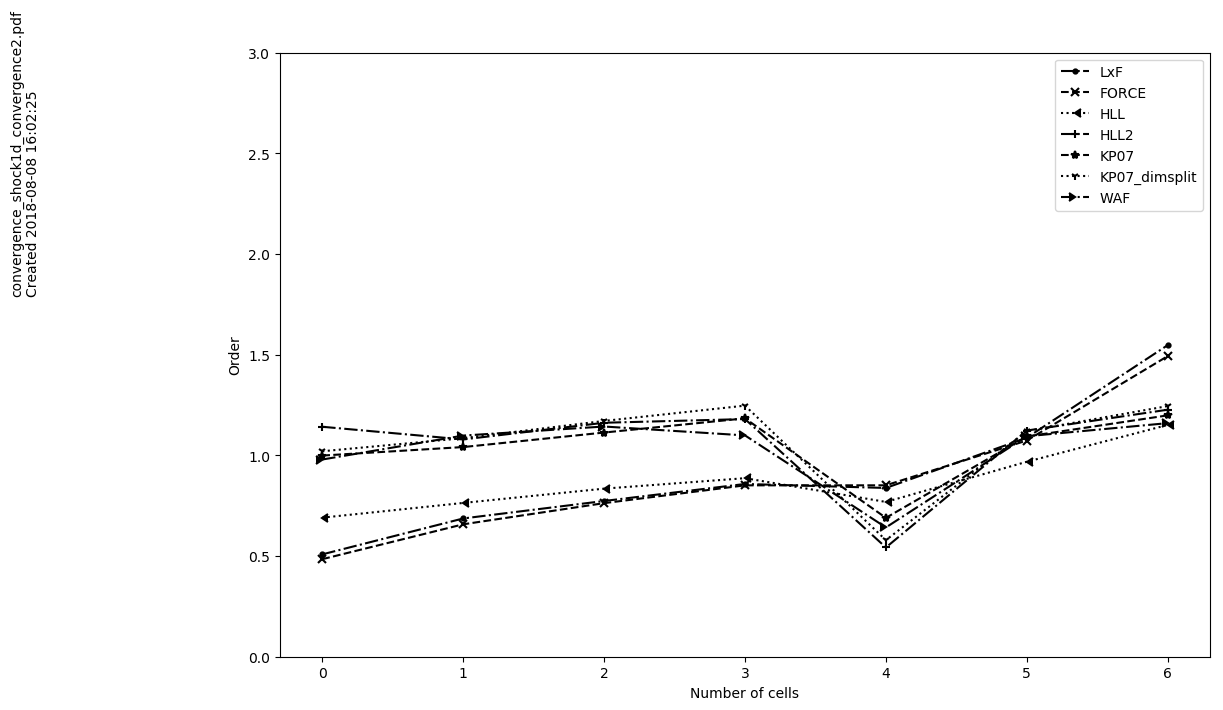

In [13]:
fig = plt.figure()
setBwStyles(fig.gca())

for i, simulator in enumerate(simulators):
    a = np.arange(1, len(domain_sizes))
    order = np.log2(error[i, :-1] / error[i, 1:])
    #order = np.log2(error[i, 0] / (error[i, 1:]) )/a
    plt.plot(order, label=simulator.__name__)
    
plt.ylim([0, 3])
plt.xlabel('Number of cells')
plt.ylabel('Order')
plt.legend()
save_figure(fig, 'convergence2')

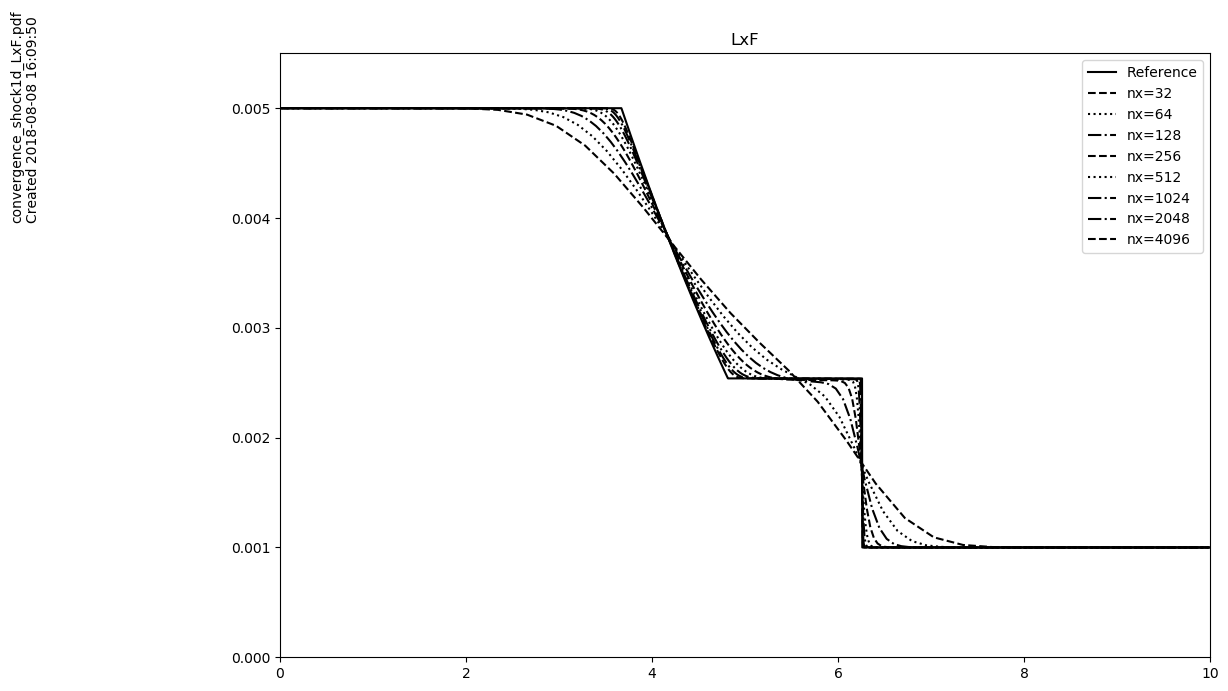

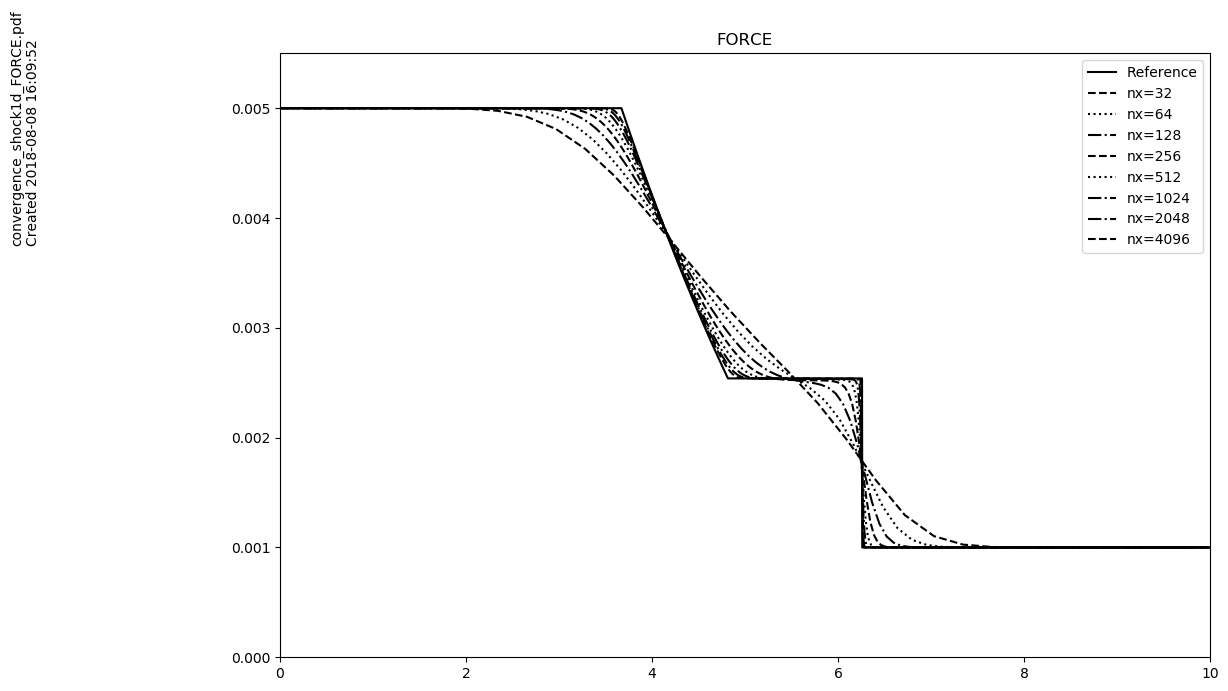

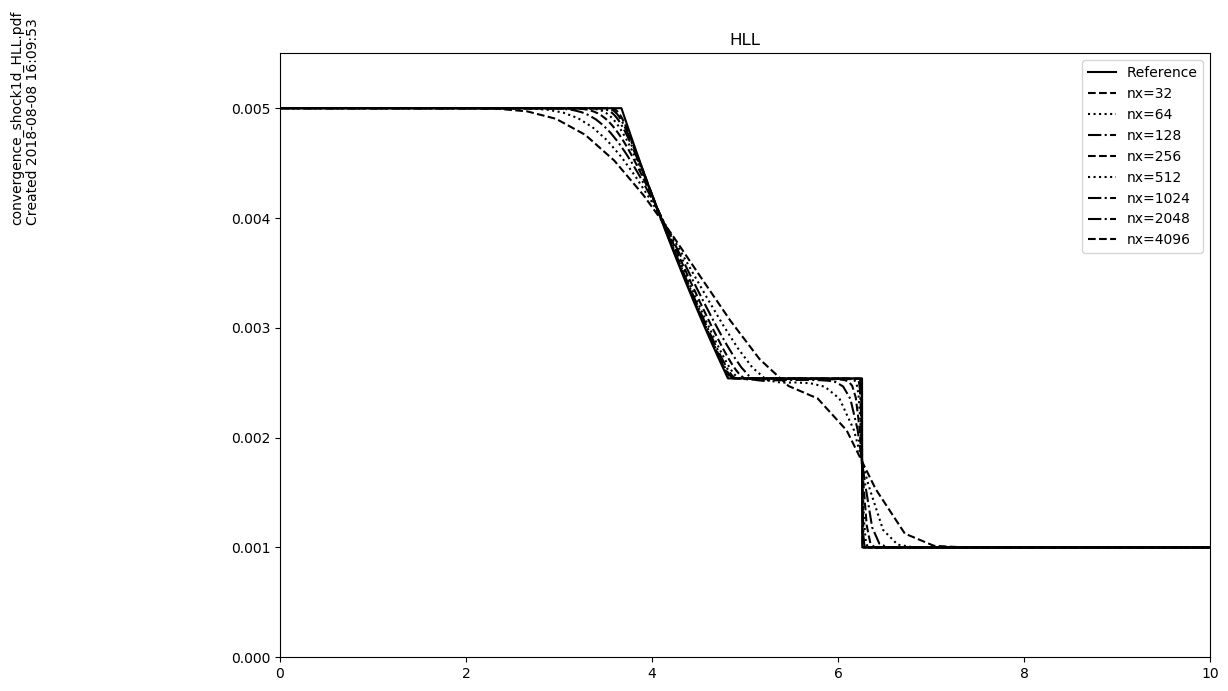

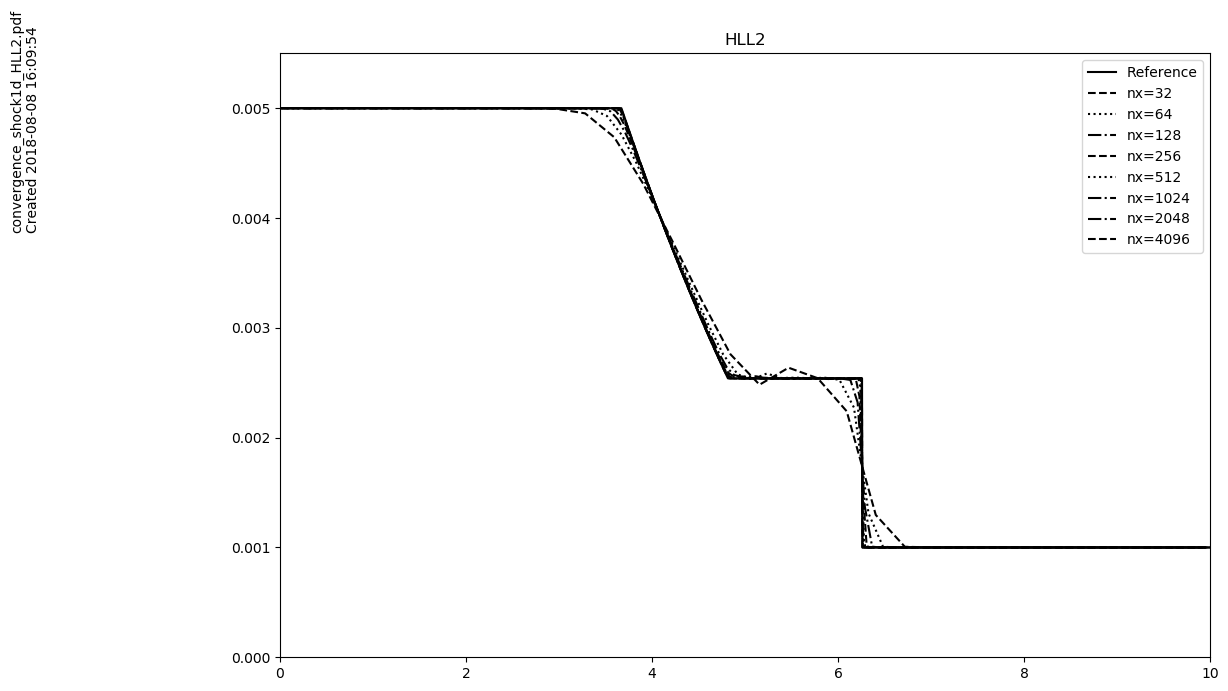

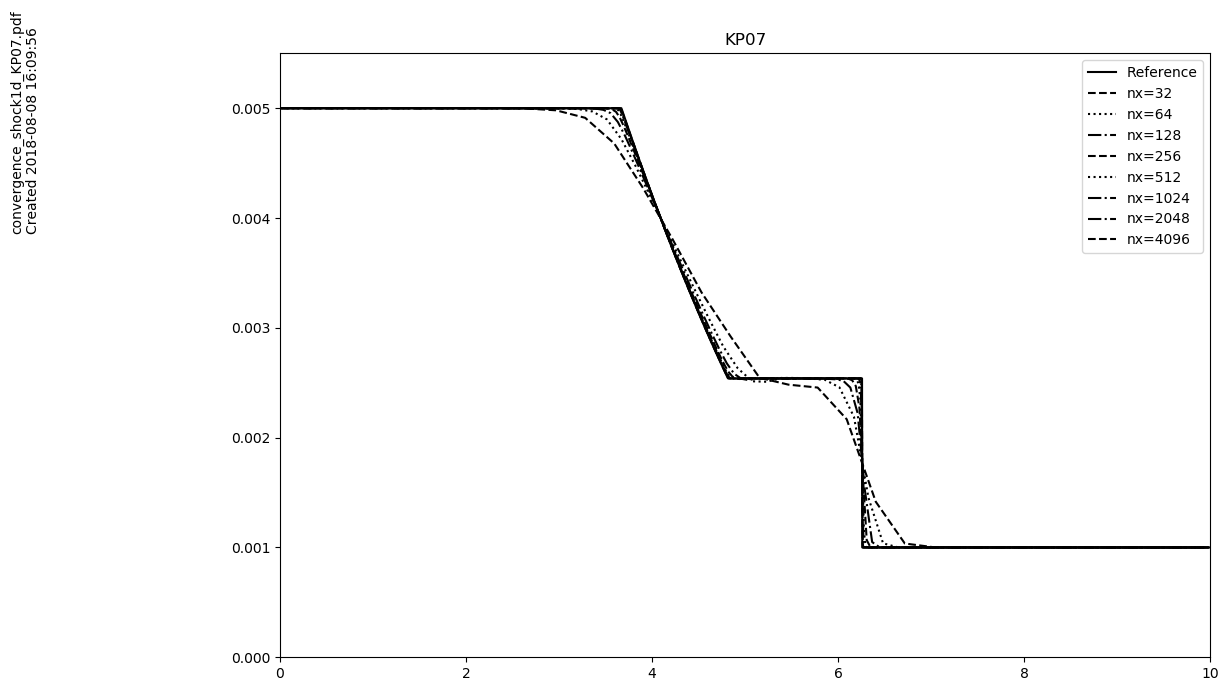

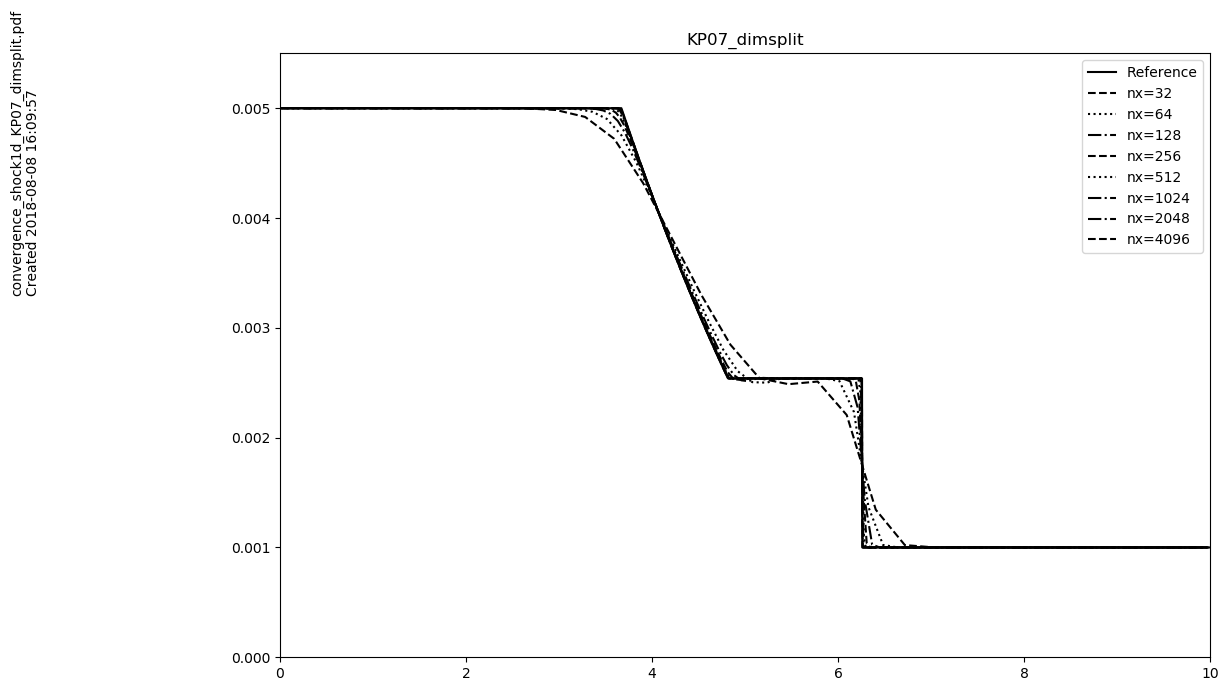

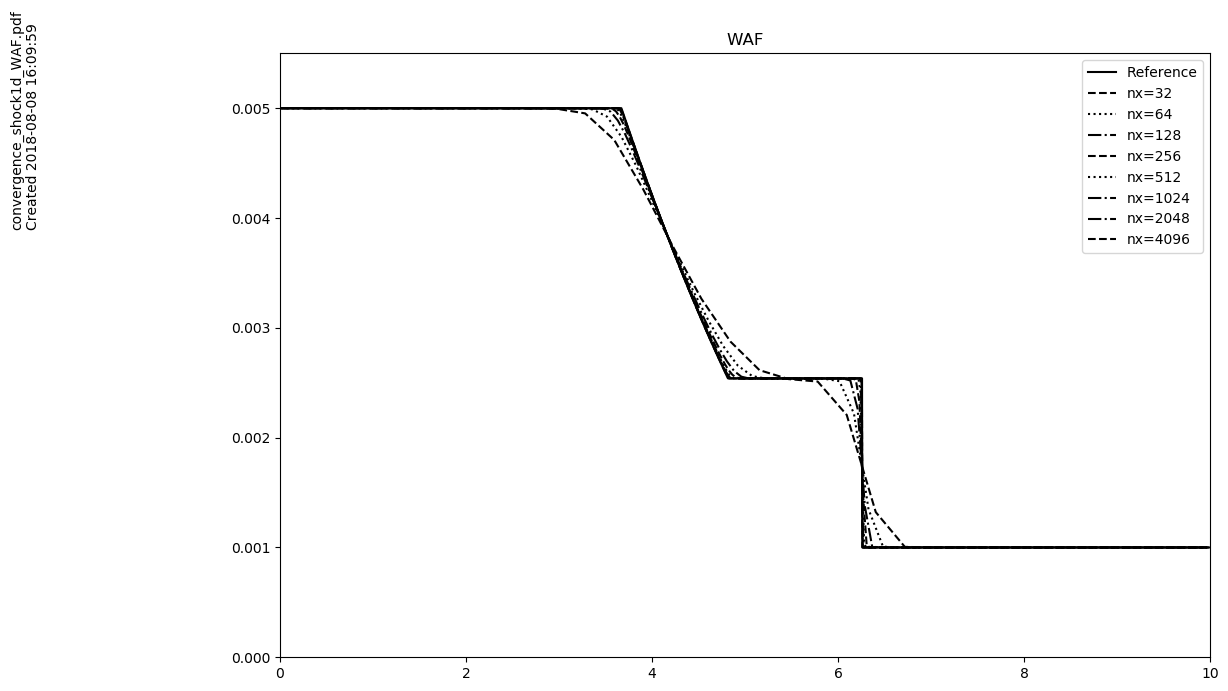

In [18]:
def plot_solution(simulator, nx, label, **kwargs):
    datafilename = gen_filename(simulator, nx)
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        
    x = np.linspace(0.5, nx-0.5, nx)*10.0/float(nx)
    
    plt.plot(x, h, label=label, **kwargs)
    
    h = None
    x = None
    gc.collect() # Force run garbage collection to free up memory

for simulator in simulators:
    fig = plt.figure()
    setBwStyles(fig.gca())
    
    #Plot reference solution
    ref_x, ref_h, _ = gen_reference(4096)
    plt.plot(ref_x, ref_h, '-', label='Reference')
    ref_x = None
    ref_h = None
    gc.collect()
    
    #Plot simulation results
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')
    plt.title(str(simulator.__name__))
    plt.axis([0, 10, 0, 0.0055])
    plt.legend()
    
    save_figure(fig, simulator.__name__)

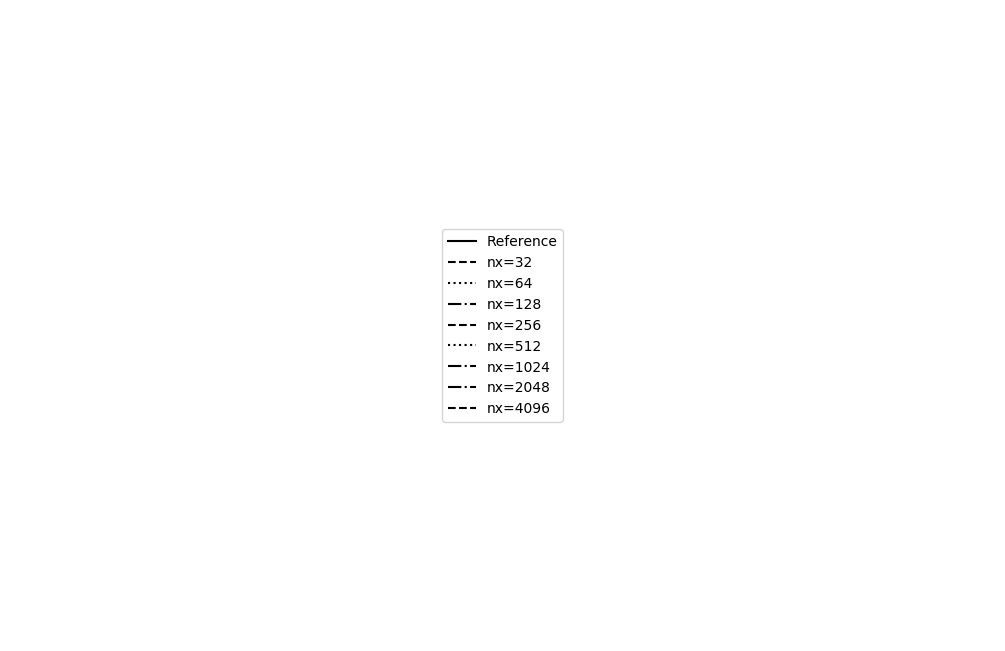

In [15]:
figLegend = plt.figure()#figsize = (1.5,1.3))
plt.plot(0, 0)
plt.figlegend(*fig.gca().get_legend_handles_labels(), loc = 'center')
plt.axis('off')
plt.show()

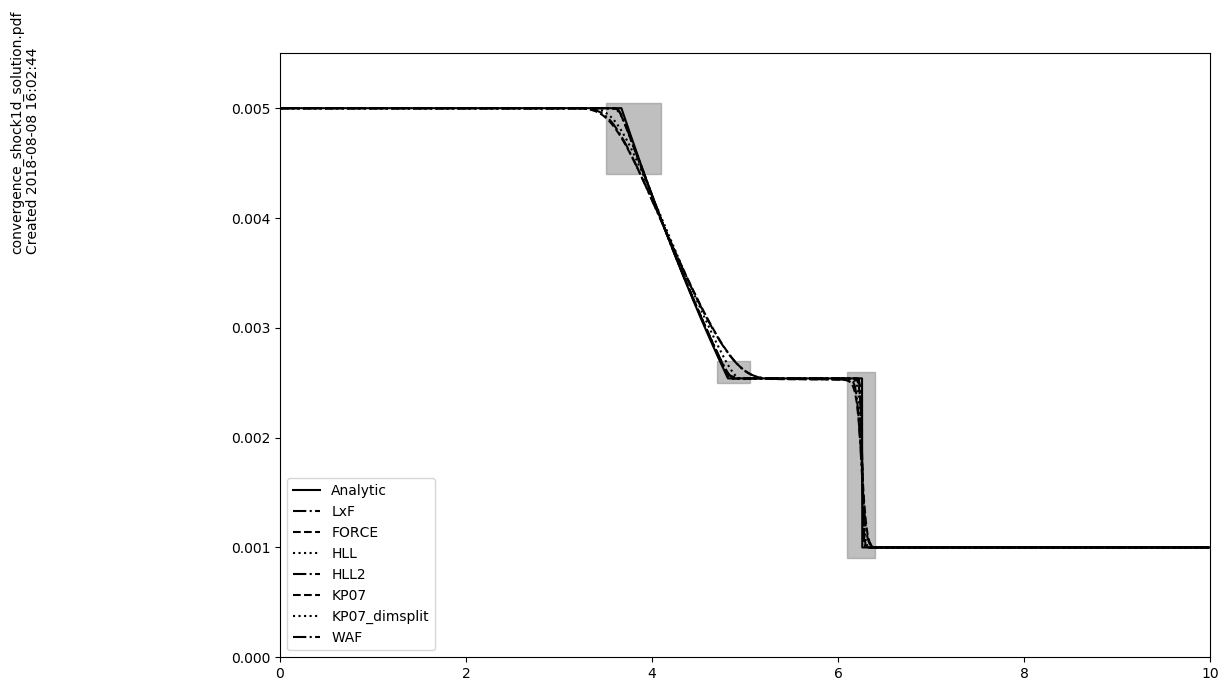

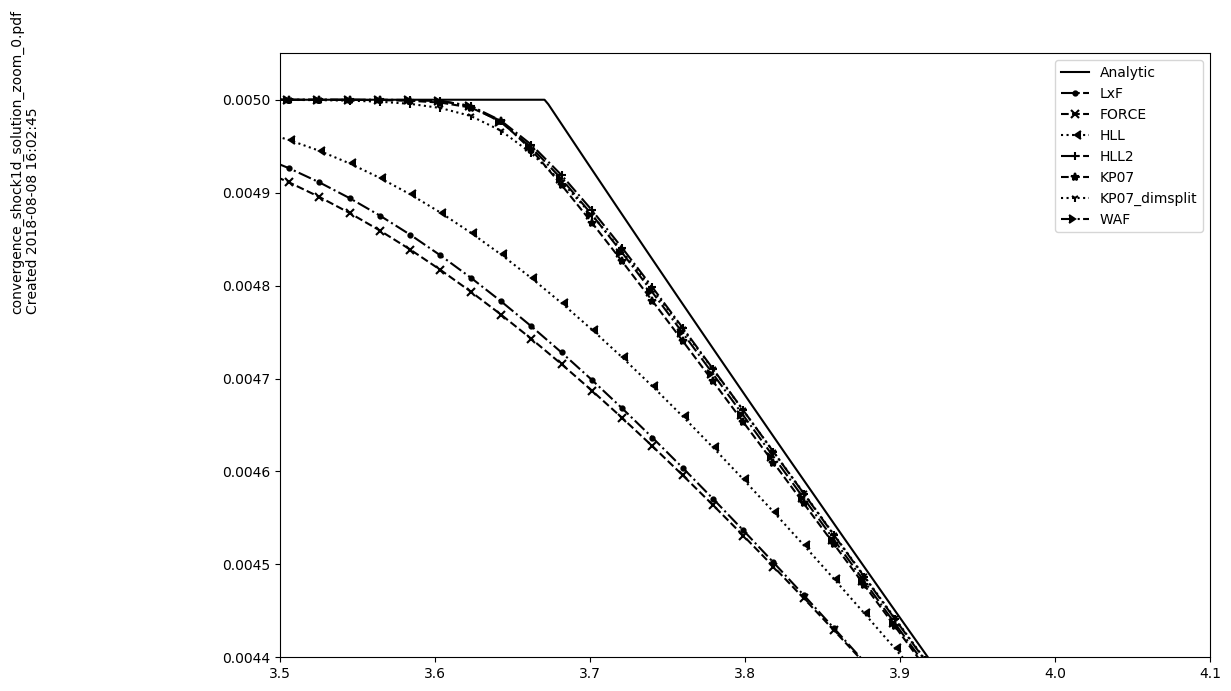

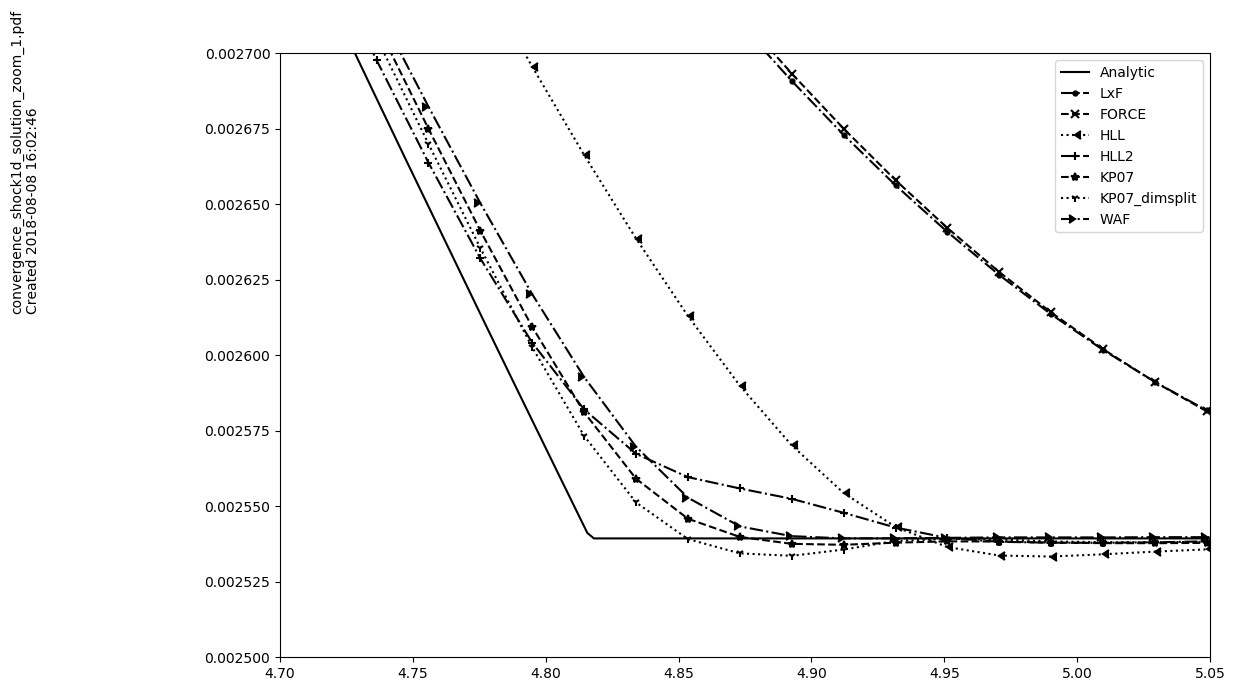

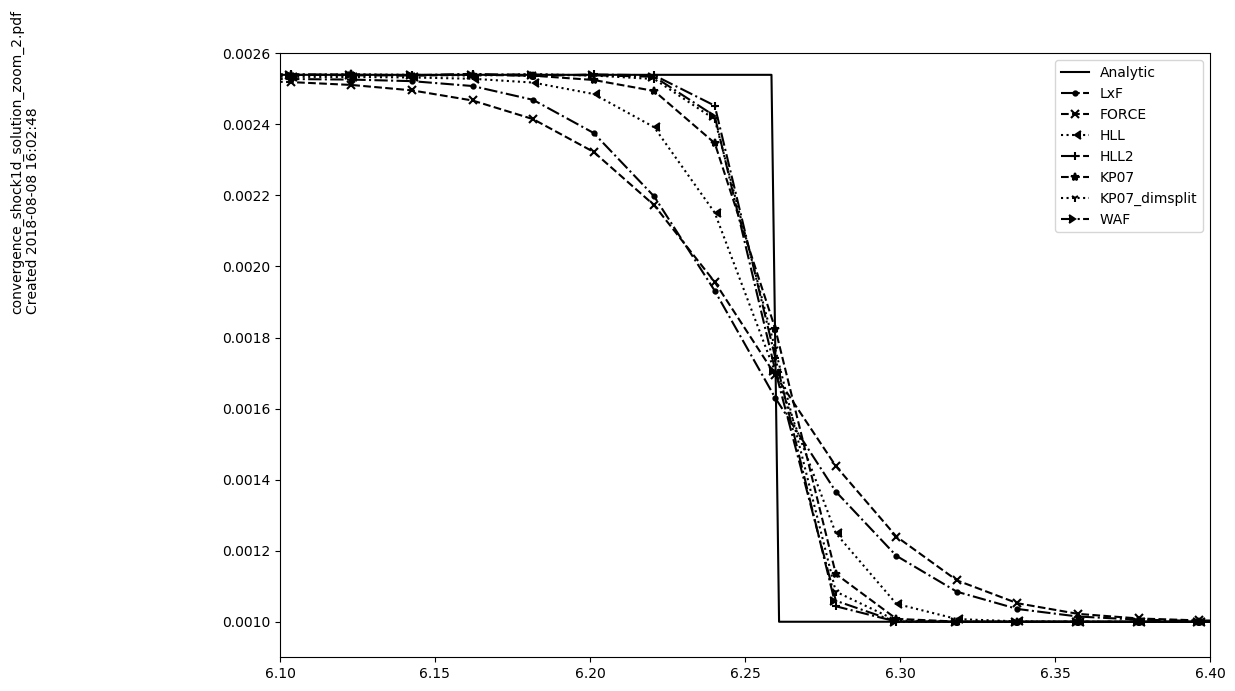

In [16]:
def plot_comparison(**kwargs):
    ref_x, ref_h, _ = gen_reference(4096)
    plt.plot(ref_x, ref_h, '-', color='black', label='Analytic')
    ref_x = None
    ref_h = None
    gc.collect()

    for i, simulator in enumerate(simulators):
        nx = 512
        plot_solution(simulator, nx, simulator.__name__, **kwargs)
        

fig = plt.figure()
setBwStyles(fig.gca())

boxes = np.array([\
         [[3.5, 4.1], [0.0044, 0.00505]], \
         [[4.7, 5.05], [0.0025, 0.0027]],  \
         [[6.1, 6.40], [0.0009, 0.0026]] \
         ])

plot_comparison(marker=' ')
for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
plt.xlim([0, 10])
plt.ylim([0, 0.0055])
plt.legend(loc='lower left')
save_figure(fig, 'solution')

for i, bbox in enumerate(boxes):
    fig = plt.figure()
    setBwStyles(fig.gca())
    plot_comparison()
    plt.xlim(bbox[0])
    plt.ylim(bbox[1])
    plt.legend()
    
    save_figure(fig, "solution_zoom_" + str(i))
